# Milestone #1: Data Investigation

My first step is to investigate my data options for this project. As discussed in my [plan](/itp/project_development_studio/plan/), I am considering Google Streetview data and LiDAR data. The Streetview data is my first choice but I realized that that data might be different from what I expect or have weird complications that make it difficult or impossible to do what I have in mind. I wanted to consider alternatives, and there's a lot that interests me about LiDAR data. Of course that data might be impossible to work with too. In any case, I needed to find out these things right away while it is still easy to change course on this project.

The summary of Google Streetview data is that it is easy to work with and close to what I expected. They provide a convenient API that is properly documented. Unfortunately, the depth data discussed [in this blog post](https://medium.com/@nocomputer/creating-point-clouds-with-google-street-view-185faad9d4ee) does not come from the API, and that information is compressed in a format I have not yet parsed. The author of that post does provide C++ code for doing so; I am optimistic that I will be able to translate that to Python and/or integrate their process into my code.

LiDAR data is also well documented but extremely complex. I've worked with complex data before and am confident I can manage this if I put in the time. My objection is that taking the project in that direction would take a good portion of the class. I would have less time to learn about the topics I want to be learning about.

Additionally, I feel the challenges I would face with the Google Streetview data is resonating with me in a way that the LiDAR data challenges are not.

My conclusion is that I will use the Google Streetview data for this project. Sometime after the semester is over I might spend more time with the LiDAR data and get some experience working with it. It would be a great choice for a future project.

<!-- TEASER_END -->

## Working with Google Streetview data

Using the Google Streetview API is easy in Python.

First, import a few packages.

In [1]:
import requests
from IPython.display import Image

The [API documentation](https://developers.google.com/maps/documentation/streetview/intro) says that users should use an API key. The [free plan ](https://developers.google.com/maps/documentation/streetview/usage-limits) allows for 25K requests per day with a maximum image resolution of 640x640.

In [2]:
with open('../secrets/google_street_view_image_api.txt.nogit', 'r') as f:
    api_key = f.read()

This is the basic URL format I can use for image metadata:

In [3]:
API_METADATA_URL = ("https://maps.googleapis.com/maps/api/streetview/metadata?"
                    "location={0},{1}&key={2}")

I can pick a location using latitude and longitude. Using my API key, I can construct the URL.

In [4]:
location = (40.7293934, -73.9934632)

url = API_METADATA_URL.format(location[0], location[1], api_key)

With the Python `requests` library I can easily request the URL and parse the response.

In [5]:
response = requests.get(url)

response.json()

{'copyright': '© Google, Inc.',
 'date': '2017-09',
 'location': {'lat': 40.72939870242668, 'lng': -73.99343724185765},
 'pano_id': '4ElQmDQdNK49Kc_Mxjp1Tw',
 'status': 'OK'}

The OK status tells me if I make a request for streetview data I will get a valid response. The other information is also useful but I won't get into that here.

Here is the URL for image data:

In [6]:
API_URL = ("https://maps.googleapis.com/maps/api/streetview?"
           "location={0},{1}&size=640x640&heading={2}&fov=90&pitch={3}&key={4}")

I need to specify a viewing direction with `heading` and `pitch`:

In [7]:
heading = 354
pitch = 0

I can again construct the URL and fetch the data.

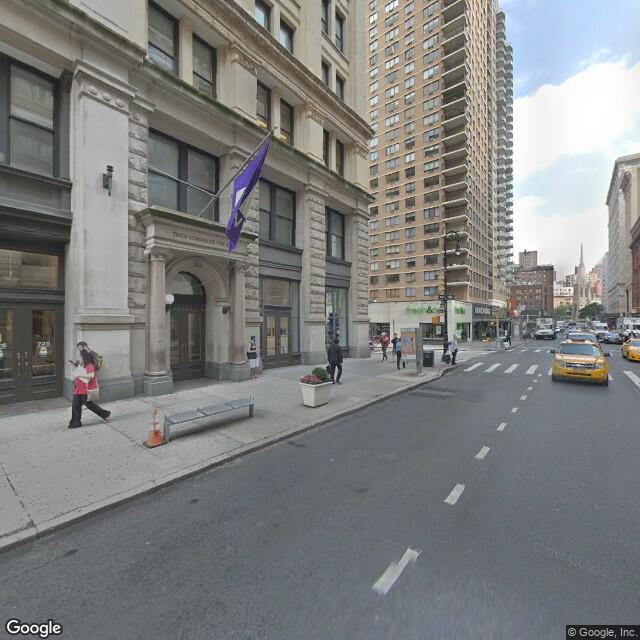

In [8]:
url = API_URL.format(location[0], location[1], heading, pitch, api_key)

response = requests.get(url)

Image(response.content)

This is the current home of ITP.

I can change the heading to look in another direction.

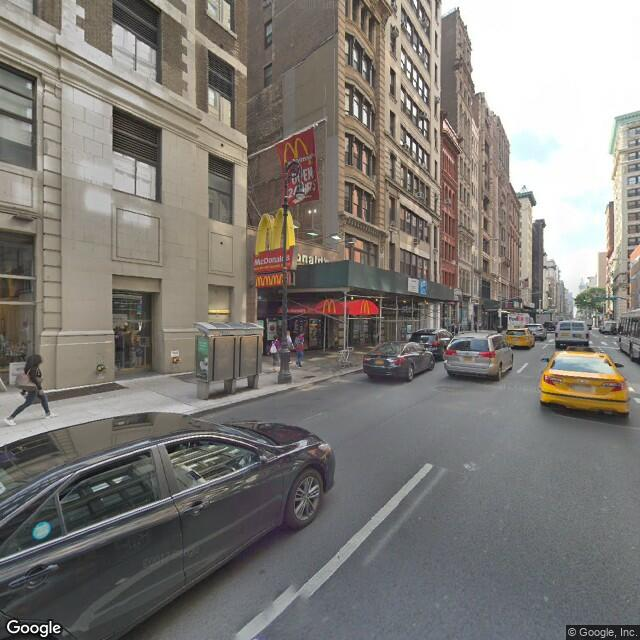

In [9]:
heading -= 180

url = API_URL.format(location[0], location[1], heading, pitch, api_key)

response = requests.get(url)

Image(response.content)

If I change the pitch I can look up or down.

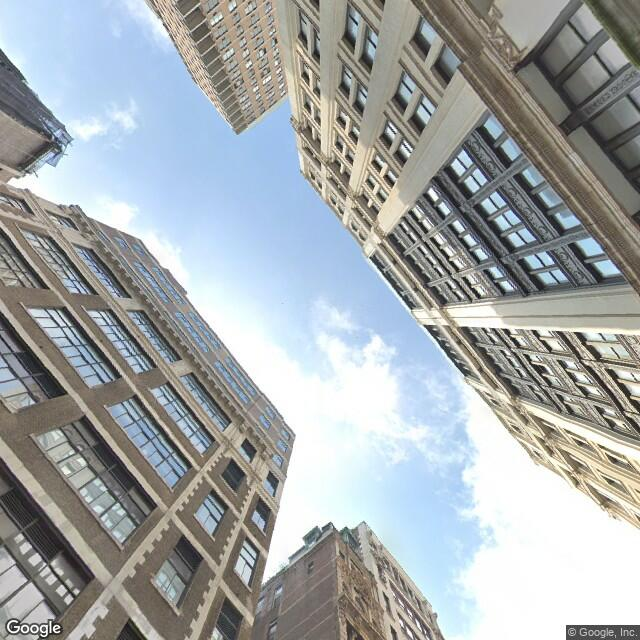

In [10]:
pitch = 90

url = API_URL.format(location[0], location[1], heading, pitch, api_key)

response = requests.get(url)

Image(response.content)

Using a FOV (field of view) of 90 degrees I can make 6 queries to fetch pictures for 6 faces of an imaginary cube. These 6 pictures can be assembled into the equirectangular projection format used in 360 video.

I have experience working with equirectangular projections from my efforts extending [Camera3D](http://ixora.io/projects/camera-3D/) to support [360 videos](http://ixora.io/projects/camera-3D/monoscopic-360-video/). From [deriving the equations for optimal sizing](http://ixora.io/projects/camera-3D/monoscopic-360-video-optimization/) I know that 640x640 cube faces will get me 360 video resolution of about 2K. That would be a little bit pixelated in a 360 video player but it should be more than enough for my purposes here.

## Depth data

What about the depth data? Other projects that used this data employed depth data. That doesn't come from the API. It comes from specific URL requests to Google's servers.

In [11]:
url = "http://maps.google.com/cbk?output=json&ll={0},{1}&dm=1".format(*location)

response = requests.get(url)

response.json()

{'Data': {'copyright': '© 2018 Google',
  'image_date': '2017-09',
  'image_height': '8192',
  'image_width': '16384',
  'imagery_type': 1,
  'tile_height': '512',
  'tile_width': '512'},
 'Links': [{'description': 'Broadway',
   'panoId': 'RMvRGNLRu7QOyXIb6i4Aqw',
   'road_argb': '0x80fdf872',
   'yawDeg': '31.23'},
  {'description': 'Broadway',
   'panoId': 'h43_C8RtuVS-eyaBTeDuLw',
   'road_argb': '0x80fdf872',
   'yawDeg': '211.38'}],
 'Location': {'best_view_direction_deg': '254.966',
  'country': 'United States',
  'description': '725 Broadway',
  'elevation_egm96_m': '17.854675',
  'elevation_wgs84_m': '-14.852387',
  'lat': '40.729399',
  'lng': '-73.993437',
  'original_lat': '40.729393',
  'original_lng': '-73.993463',
  'panoId': '4ElQmDQdNK49Kc_Mxjp1Tw',
  'region': 'New York',
  'streetRange': '725',
  'zoomLevels': '5'},
 'Projection': {'pano_yaw_deg': '211.21',
  'projection_type': 'spherical',
  'tilt_pitch_deg': '0.24',
  'tilt_yaw_deg': '-123.35'},
 'model': {'depth_m

The 'depth_map' at the end of the json response is compressed data that has been encoded in base64. I can decode base64 but I have not yet uncompressed the data with Python's `zlib` library. Next step for me is to experiment with the C++ code I found and figure out why it works and convert it to Python.

More importantly, I need to write Python code to systematically access this data and keep it organized. I've got some ideas for how to do that and will start putting that together tomorrow during our class.